# 미션 소개

쇼핑몰 리뷰 데이터를 대상으로 감성 분석을 해 보는 미션. 데이터 로드 및 전처리부터 모델 학습과 성능 평가까지 전부 구현

## 사용 데이터셋
- 데이터 형식
    - JSON 파일 형태로 제공되는 리뷰 데이터입니다. JSON 파일 하나에 여러 개의 리뷰가 포함되어 있음.
    - JSON 파일에서 리뷰 텍스트는 RawText에 있고, 리뷰에 대한 긍부정 라벨은 GeneralPolarity에 있음.    GeneralPolarity 값은 -1일 때 부정, 0일 때 중립, 1일 때 긍정을 뜻함.
- 데이터 구성
    - 패션, 화장품, 가전, IT기기, 생활 5가지 분야에 대해 쇼핑몰과 SNS에 달린 리뷰. 원하는 분야의 리뷰를 선택하여 모델을 학습시키고 성능을 평가해보기.

## 가이드라인
- 데이터 로드 및 전처리
    - 리뷰 데이터를 로드하고, 감성 분석 모델을 학습시키기 위한 형식으로 적절하게 변환.
    - 전체 데이터를 학습 데이터와 테스트 데이터로 분할.
- Full Fine-Tuning 방식으로 모델 학습
    - Hugging Face의 transformers 라이브러리를 활용해 감성 분석 모델을 학습시킨다.
- PEFT 방식으로 모델 학습
    - Hugging Face의 peft 라이브러리를 추가로 활용해 PEFT 방식으로 감성 분석 모델을 학습시킨다.
- 두 가지 학습 방식 비교
    - Full Fine-Tuning 방식과 PEFT 방식의 학습 속도를 비교하기.
    - 각 방식으로 학습시킨 모델 파일을 저장한 뒤 용량을 비교해 보기.
    - 리뷰 텍스트의 실제 라벨과 모델이 예측한 결과를 비교하여 감성 분석 모델의 성능을 평가. 두 가지 학습 방식 사이에 정확도 차이가 있는지 확인해 보기.
- 원본 데이터셋 링크
    - https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=71603

## 📦 환경 설정 및 라이브러리 설치

In [1]:
!pip install transformers datasets
!pip install peft
!pip install konlpy
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

In [2]:
# 기본 라이브러리 임포트
import os, sys, math, time, json, random, shutil, pathlib, zipfile
from typing import List, Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Hugging Face 라이브러리
import evaluate
from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)

from peft import LoraConfig, get_peft_model, TaskType

print("✅ 모든 라이브러리가 성공적으로 로드되었습니다!")

✅ 모든 라이브러리가 성공적으로 로드되었습니다!


In [3]:
# 디바이스 자동 감지 및 설정
def get_device():
    """사용 가능한 최적의 디바이스를 자동으로 감지"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = "CUDA"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        device_name = "MPS"
    else:
        device = torch.device("cpu")
        device_name = "CPU"
    
    return device, device_name

device, device_name = get_device()
print(f"PyTorch: {torch.__version__}, Device: {device_name} ({device})")

# 각 디바이스별 지원 기능 확인
def get_training_config(device):
    """디바이스별 최적화된 학습 설정 반환"""
    config = {
        'device': device,
        'fp16': False,
        'gradient_checkpointing': False
    }

    if device.type == 'cuda':
        config['fp16'] = True  # CUDA는 FP16 지원
        config['gradient_checkpointing'] = True
    elif device.type == 'mps':
        # MPS는 기본적으로 FP16 지원하지 않음
        config['fp16'] = False
        config['gradient_checkpointing'] = False  # MPS에서는 gradient checkpointing 제한적 지원

    return config

training_config = get_training_config(device)
print(f"학습 설정: FP16={training_config['fp16']}, Gradient Checkpointing={training_config['gradient_checkpointing']}")


PyTorch: 2.8.0, Device: MPS (mps)
학습 설정: FP16=False, Gradient Checkpointing=False


In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

# 나눔 폰트가 없는 경우를 대비한 대체 폰트 설정
try:
    # 나눔 폰트가 설치되어 있는지 확인
    path = '../NanumGothic.ttf'
    font_name = fm.FontProperties(fname=path, size=10).get_name()
    plt.rc('font', family=font_name)
    fm.fontManager.addfont(path)
    print("나눔 폰트를 성공적으로 설정했습니다.")
except:
    # 나눔 폰트가 없는 경우 기본 폰트 사용
    print("나눔 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    plt.rc('font', family='DejaVu Sans')  # 기본 폰트

나눔 폰트를 성공적으로 설정했습니다.


## ⚙️ 설정 (경로/모델/하이퍼파라미터)

In [5]:
# === 데이터 경로 ===
# 현재 작업 디렉토리 기준으로 데이터 경로 설정
DATA_DIR = "data/review-sentiment-analysis"  # 압축 해제된 데이터 폴더
GLOB_PATTERN = "**/*.json"  # 모든 하위 폴더의 JSON 파일 탐색

# 필드명 (데이터셋 스키마)
TEXT_FIELD = "RawText"
LABEL_FIELD = "GeneralPolarity"

# 라벨 매핑 (3-클래스: 부정/중립/긍정)
LABEL_MAP = {-1: 0, 0: 1, 1: 2}
ID2LABEL = {0: "negative", 1: "neutral", 2: "positive"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

# 도메인 필터 (원하는 카테고리만 선택, None이면 전체)
# 예: ["패션", "화장품"] 또는 None
DOMAIN_FILTER = ["IT기기"]

# === 모델 설정 ===
# 한국어에 최적화된 모델 사용
BASE_MODEL_NAME = "klue/bert-base"
MAX_LENGTH = 256  # 최대 토큰 길이

# === 학습 하이퍼파라미터 ===
SEED = 42
EPOCHS = 2  # Full FT와 PEFT 모두 동일 epoch
BATCH_SIZE = 8
LR_FT = 5e-5      # Full Fine-Tuning 학습률
LR_PEFT = 1e-4    # PEFT 학습률 (보통 더 높게 설정)

# === 출력 경로 ===
OUT_DIR = "outputs"
FT_DIR = os.path.join(OUT_DIR, "full_ft_model")
PEFT_DIR = os.path.join(OUT_DIR, "peft_lora_adapter")

# 디렉토리 생성
os.makedirs(OUT_DIR, exist_ok=True)

# 랜덤 시드 고정
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    # 디바이스별 랜덤 시드 설정
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(SEED)
    elif device.type == 'mps':
        # MPS에서도 시드 고정을 위해 추가 설정
        torch.mps.manual_seed(SEED)

# 유틸리티 함수
def human_mb(bytes_size: int) -> float:
    """바이트를 MB로 변환"""
    return round(bytes_size / (1024 * 1024), 2)

def dir_size_mb(path: str) -> float:
    """디렉토리 전체 크기를 MB로 계산"""
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            if os.path.isfile(fp):
                total += os.path.getsize(fp)
    return human_mb(total)

print("✅ 설정이 완료되었습니다!")
print(f"- 데이터 디렉토리: {DATA_DIR}")
print(f"- 기본 모델: {BASE_MODEL_NAME}")
print(f"- 배치 크기: {BATCH_SIZE}, 에폭: {EPOCHS}")

✅ 설정이 완료되었습니다!
- 데이터 디렉토리: data/review-sentiment-analysis
- 기본 모델: klue/bert-base
- 배치 크기: 8, 에폭: 2


## 📥 데이터 로드 및 전처리

In [6]:
def _extract_records_from_json(obj):
    """
    다양한 JSON 스키마를 견고하게 파싱하여
    [{TEXT_FIELD: str, LABEL_FIELD: int, domain: str}] 리스트로 반환
    """
    records = []
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict):
                records.append(item)
    elif isinstance(obj, dict):
        if "reviews" in obj and isinstance(obj["reviews"], list):
            for item in obj["reviews"]:
                if isinstance(item, dict):
                    records.append(item)
        else:
            records.append(obj)
    return records

def load_json_files(data_dir: str, glob_pattern: str = "**/*.json") -> pd.DataFrame:
    """
    지정된 디렉토리에서 모든 JSON 파일을 로드하여 DataFrame으로 반환
    """
    import glob
    paths = glob.glob(os.path.join(data_dir, glob_pattern), recursive=True)
    rows = []
    
    print(f"🔍 {len(paths)}개의 JSON 파일을 찾았습니다.")
    
    for i, p in enumerate(paths):
        if (i + 1) % 50 == 0:  # 진행상황 표시
            print(f"  - {i+1}/{len(paths)} 파일 처리 중...")
            
        try:
            with open(p, "r", encoding="utf-8") as f:
                obj = json.load(f)
            recs = _extract_records_from_json(obj)
            
            for r in recs:
                if TEXT_FIELD in r and LABEL_FIELD in r:
                    rows.append({
                        "text": str(r[TEXT_FIELD]),
                        "label_raw": int(r[LABEL_FIELD]),
                        "domain": r.get("Domain") or r.get("MainCategory") or "기타",
                        "source": r.get("Source") or "unknown",
                        "__src__": p
                    })
        except Exception as e:
            print(f"⚠️  JSON 파싱 실패: {p} -> {e}")
    
    df = pd.DataFrame(rows)
    return df

def basic_clean(text: str) -> str:
    """기본적인 텍스트 전처리"""
    # 줄바꿈 제거 및 앞뒤 공백 제거
    text = text.replace("\n", " ").replace("\r", " ").strip()
    # 여러 공백을 하나로 통합
    import re
    text = re.sub(r'\s+', ' ', text)
    return text

# 데이터 로드
print("📂 JSON 파일들을 로드하는 중...")
df = load_json_files(DATA_DIR, GLOB_PATTERN)

if len(df) == 0:
    raise RuntimeError("❌ 데이터가 로드되지 않았습니다. 데이터 경로와 JSON 스키마를 확인하세요.")

# 도메인 필터 적용 (선택사항)
if DOMAIN_FILTER:
    df = df[df["domain"].isin(DOMAIN_FILTER)]
    print(f"📊 도메인 필터 적용: {DOMAIN_FILTER}")

# 라벨 변환
df["label"] = df["label_raw"].map(LABEL_MAP)
NUM_LABELS = 3  # 3-클래스 분류

# 텍스트 전처리
df["text"] = df["text"].astype(str).map(basic_clean)

# 결측치 제거
df = df.dropna(subset=["text", "label"]).reset_index(drop=True)

# 데이터 정보 출력
print("\n" + "="*50)
print("📊 데이터 로드 완료!")
print(f"- 총 샘플 수: {len(df):,}")
print(f"- 도메인 분포:")
print(df["domain"].value_counts())
print(f"\n- 라벨 분포:")
label_counts = df["label"].value_counts().sort_index()
for label_id, count in label_counts.items():
    label_name = ID2LABEL[label_id]
    print(f"  {label_name} (id={label_id}): {count:,} ({count/len(df)*100:.1f}%)")

# 샘플 데이터 출력
print(f"\n- 샘플 데이터:")
display(df.head(3))

📂 JSON 파일들을 로드하는 중...
🔍 2026개의 JSON 파일을 찾았습니다.
  - 50/2026 파일 처리 중...
  - 100/2026 파일 처리 중...
  - 150/2026 파일 처리 중...
  - 200/2026 파일 처리 중...
  - 250/2026 파일 처리 중...
  - 300/2026 파일 처리 중...
  - 350/2026 파일 처리 중...
  - 400/2026 파일 처리 중...
  - 450/2026 파일 처리 중...
  - 500/2026 파일 처리 중...
  - 550/2026 파일 처리 중...
  - 600/2026 파일 처리 중...
  - 650/2026 파일 처리 중...
  - 700/2026 파일 처리 중...
  - 750/2026 파일 처리 중...
  - 800/2026 파일 처리 중...
  - 850/2026 파일 처리 중...
  - 900/2026 파일 처리 중...
  - 950/2026 파일 처리 중...
  - 1000/2026 파일 처리 중...
  - 1050/2026 파일 처리 중...
  - 1100/2026 파일 처리 중...
  - 1150/2026 파일 처리 중...
  - 1200/2026 파일 처리 중...
  - 1250/2026 파일 처리 중...
  - 1300/2026 파일 처리 중...
  - 1350/2026 파일 처리 중...
  - 1400/2026 파일 처리 중...
  - 1450/2026 파일 처리 중...
  - 1500/2026 파일 처리 중...
  - 1550/2026 파일 처리 중...
  - 1600/2026 파일 처리 중...
  - 1650/2026 파일 처리 중...
  - 1700/2026 파일 처리 중...
  - 1750/2026 파일 처리 중...
  - 1800/2026 파일 처리 중...
  - 1850/2026 파일 처리 중...
  - 1900/2026 파일 처리 중...
  - 1950/2026 파일 처리 중..

,text,label_raw,domain,source,__src__,label
0,얼마전 남자친구가 100일 기념으로 워치를 선물해 줬어요. 제가 평소에 갖고 싶어하...,0,IT기기,SNS,data/review-sentiment-analysis/SNS/04. IT기기/...,1
1,평소 야외에서 일을 할때는 주변에 방해가 될까봐 진동으로 해놓고 일을 하다 보니 전...,1,IT기기,SNS,data/review-sentiment-analysis/SNS/04. IT기기/...,2
2,이번에 구매한 제품은 워치입니다. 벌써 구매하고 사용한지 한달이나 지났네요. 워치는...,0,IT기기,SNS,data/review-sentiment-analysis/SNS/04. IT기기/...,1


## 🔀 학습/검증/테스트 분할

In [7]:
# 데이터 분할 (학습:검증:테스트 = 70:15:15)
# 먼저 학습+검증과 테스트로 분할
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.15, 
    random_state=SEED, 
    stratify=df["label"]  # 라벨별로 균등하게 분할
)

# 학습+검증을 학습과 검증으로 분할
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.176,  # 15/(70+15) ≈ 0.176
    random_state=SEED,
    stratify=train_val_df["label"]
)

print("📊 데이터 분할 결과:")
print(f"- 학습 데이터: {len(train_df):,}개 ({len(train_df)/len(df)*100:.1f}%)")
print(f"- 검증 데이터: {len(val_df):,}개 ({len(val_df)/len(df)*100:.1f}%)")
print(f"- 테스트 데이터: {len(test_df):,}개 ({len(test_df)/len(df)*100:.1f}%)")

# 각 데이터셋의 라벨 분포 확인
print("\n📈 라벨 분포 확인:")
for name, split_df in [("학습", train_df), ("검증", val_df), ("테스트", test_df)]:
    print(f"\n{name} 데이터 라벨 분포:")
    for label_id in range(3):
        count = (split_df["label"] == label_id).sum()
        pct = count / len(split_df) * 100
        print(f"  {ID2LABEL[label_id]}: {count:,} ({pct:.1f}%)")

# Hugging Face Dataset으로 변환
train_ds = Dataset.from_pandas(train_df[["text", "label"]], preserve_index=False)
val_ds = Dataset.from_pandas(val_df[["text", "label"]], preserve_index=False)
test_ds = Dataset.from_pandas(test_df[["text", "label"]], preserve_index=False)

raw_datasets = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

print(f"\n✅ 데이터 분할 완료!")
print(f"Dataset 구조: {raw_datasets}")

📊 데이터 분할 결과:
- 학습 데이터: 28,301개 (70.0%)
- 검증 데이터: 6,045개 (15.0%)
- 테스트 데이터: 6,062개 (15.0%)

📈 라벨 분포 확인:

학습 데이터 라벨 분포:
  negative: 2,649 (9.4%)
  neutral: 8,734 (30.9%)
  positive: 16,918 (59.8%)

검증 데이터 라벨 분포:
  negative: 566 (9.4%)
  neutral: 1,866 (30.9%)
  positive: 3,613 (59.8%)

테스트 데이터 라벨 분포:
  negative: 567 (9.4%)
  neutral: 1,871 (30.9%)
  positive: 3,624 (59.8%)

✅ 데이터 분할 완료!
Dataset 구조: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 28301
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 6045
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6062
    })
})


## 🔡 토크나이저 및 데이터셋 구성

🔤 토크나이저 로드 중: klue/bert-base
🔄 데이터 토크나이징 중...


토크나이징 진행중:   0%|          | 0/28301 [00:00<?, ? examples/s]

토크나이징 진행중:   0%|          | 0/6045 [00:00<?, ? examples/s]

토크나이징 진행중:   0%|          | 0/6062 [00:00<?, ? examples/s]


✅ 토크나이징 완료!
토크나이징된 데이터셋 구조: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 28301
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6045
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6062
    })
})

샘플 토큰 길이: 26
샘플 라벨: 1 (neutral)


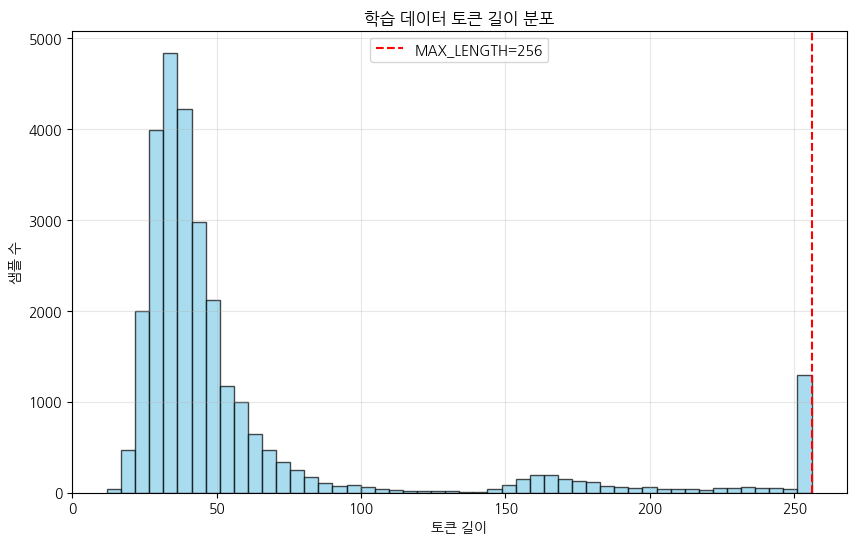


📊 토큰 길이 통계:
- 평균 길이: 60.2
- 최대 길이: 256
- 95% 백분위수: 240.0
- 잘린 샘플 비율: 4.4%


In [8]:
# 토크나이저 로드
print(f"🔤 토크나이저 로드 중: {BASE_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True)

# 토크나이징 함수 정의
def tokenize_fn(batch):
    """배치 단위 토크나이징"""
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False  # DataCollator에서 처리
    )

# 데이터셋 토크나이징
print("🔄 데이터 토크나이징 중...")
tok_datasets = raw_datasets.map(
    tokenize_fn, 
    batched=True, 
    remove_columns=["text"],
    desc="토크나이징 진행중"
)

# 데이터 콜레이터 설정 (동적 패딩)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 토크나이징 결과 확인
print("\n✅ 토크나이징 완료!")
print(f"토크나이징된 데이터셋 구조: {tok_datasets}")

# 샘플 확인
sample = tok_datasets["train"][0]
print(f"\n샘플 토큰 길이: {len(sample['input_ids'])}")
print(f"샘플 라벨: {sample['label']} ({ID2LABEL[sample['label']]})")

# 토큰 길이 분포 확인
train_lengths = [len(x['input_ids']) for x in tok_datasets["train"]]
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('학습 데이터 토큰 길이 분포')
plt.xlabel('토큰 길이')
plt.ylabel('샘플 수')
plt.axvline(MAX_LENGTH, color='red', linestyle='--', label=f'MAX_LENGTH={MAX_LENGTH}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 토큰 길이 통계:")
print(f"- 평균 길이: {np.mean(train_lengths):.1f}")
print(f"- 최대 길이: {np.max(train_lengths)}")
print(f"- 95% 백분위수: {np.percentile(train_lengths, 95):.1f}")
print(f"- 잘린 샘플 비율: {(np.array(train_lengths) >= MAX_LENGTH).mean()*100:.1f}%")

## 🧠 Baseline: Full Fine-Tuning

In [9]:
# 평가 메트릭 설정
metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """평가 메트릭 계산"""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    acc = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1_weighted = metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }

# Full Fine-Tuning 모델 로드
print(f"🤖 Full Fine-Tuning 모델 로드: {BASE_MODEL_NAME}")
ft_model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL_NAME, 
    num_labels=NUM_LABELS, 
    id2label=ID2LABEL, 
    label2id=LABEL2ID
)

# 학습 가능한 파라미터 수 확인
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"📊 모델 파라미터:")
print(f"- 총 파라미터: {total_params:,}")
print(f"- 학습 가능 파라미터: {trainable_params:,}")
print(f"- 학습 비율: {trainable_params/total_params*100:.1f}%")

# 학습 설정
ft_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "ft_tmp"),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_FT,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",  # evaluation_strategy → eval_strategy (transformers 4.20+)
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=3,  # 저장할 체크포인트 수 제한
    metric_for_best_model="eval_f1_macro",  # 메트릭 이름에 eval_ 접두사 추가
    greater_is_better=True,
    report_to=[],  # WandB 등 로깅 비활성화
    seed=SEED,
    # 메모리 최적화
    fp16=training_config['fp16'],  # 디바이스별 최적화된 FP16 설정
    gradient_checkpointing=training_config['gradient_checkpointing'],  # 디바이스별 메모리 최적화
    dataloader_pin_memory=False,
)

# 트레이너 설정
ft_trainer = Trainer(
    model=ft_model,
    args=ft_args,
    train_dataset=tok_datasets["train"],
    eval_dataset=tok_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 학습 시작
print("\n🚀 Full Fine-Tuning 학습 시작!")
start_time = time.perf_counter()

ft_train_result = ft_trainer.train()

ft_train_time = time.perf_counter() - start_time
print(f"⏱️  Full FT 학습 시간: {ft_train_time:.2f}초 ({ft_train_time/60:.2f}분)")

# 검증 평가
print("\n📊 검증 데이터 평가 중...")
ft_eval_result = ft_trainer.evaluate(eval_dataset=tok_datasets["validation"])
print("Full FT 검증 결과:")
for key, value in ft_eval_result.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

# 모델 저장
print(f"\n💾 모델 저장: {FT_DIR}")
if os.path.exists(FT_DIR):
    shutil.rmtree(FT_DIR)

ft_trainer.save_model(FT_DIR)
tokenizer.save_pretrained(FT_DIR)

# 저장된 모델 크기 계산
ft_size_mb = dir_size_mb(FT_DIR)
print(f"📁 Full FT 모델 크기: {ft_size_mb} MB")

# 학습 로그 출력
print("\n📈 학습 로그 요약:")
logs = ft_train_result.metrics
for key, value in logs.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

🤖 Full Fine-Tuning 모델 로드: klue/bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 모델 파라미터:
- 총 파라미터: 110,619,651
- 학습 가능 파라미터: 110,619,651
- 학습 비율: 100.0%

🚀 Full Fine-Tuning 학습 시작!


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.242200,0.317533,0.903060,0.884316,0.904285
2,0.183700,0.303615,0.918610,0.902521,0.918979


⏱️  Full FT 학습 시간: 4743.09초 (79.05분)

📊 검증 데이터 평가 중...


Full FT 검증 결과:
- eval_loss: 0.3036
- eval_accuracy: 0.9186
- eval_f1_macro: 0.9025
- eval_f1_weighted: 0.9190
- eval_runtime: 84.9330
- eval_samples_per_second: 71.1740
- eval_steps_per_second: 8.9010
- epoch: 2.0000

💾 모델 저장: outputs/full_ft_model
📁 Full FT 모델 크기: 422.97 MB

📈 학습 로그 요약:
- train_runtime: 4743.0214
- train_samples_per_second: 11.9340
- train_steps_per_second: 1.4920
- total_flos: 4709922887353950.0000
- train_loss: 0.2826
- epoch: 2.0000


## 🔧 PEFT (LoRA) 학습

In [10]:
# PEFT용 베이스 모델 로드
print(f"🤖 PEFT 베이스 모델 로드: {BASE_MODEL_NAME}")
peft_base = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL_NAME, 
    num_labels=NUM_LABELS, 
    id2label=ID2LABEL, 
    label2id=LABEL2ID
)

# LoRA 설정
target_modules = ["query", "key", "value", "dense"]  # BERT 모델의 주요 모듈

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # 시퀀스 분류 태스크
    inference_mode=False,
    r=8,                    # LoRA 랭크 (낮을수록 적은 파라미터)
    lora_alpha=16,          # LoRA 스케일링 계수
    lora_dropout=0.05,      # 드롭아웃
    target_modules=target_modules
)

# PEFT 모델 생성
peft_model = get_peft_model(peft_base, lora_config)
print("\n📊 PEFT 모델 파라미터 정보:")
peft_model.print_trainable_parameters()

# 학습 가능한 파라미터 수 계산
total_params_peft = sum(p.numel() for p in peft_model.parameters())
trainable_params_peft = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"\n- 총 파라미터: {total_params_peft:,}")
print(f"- 학습 가능 파라미터: {trainable_params_peft:,}")
print(f"- 학습 비율: {trainable_params_peft/total_params_peft*100:.3f}%")
print(f"- Full FT 대비 파라미터 절약: {((trainable_params - trainable_params_peft) / trainable_params * 100):.1f}%")

# PEFT 학습 설정
peft_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "peft_tmp"),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR_PEFT,  # PEFT는 일반적으로 더 높은 학습률 사용
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",  # evaluation_strategy → eval_strategy (transformers 4.20+)
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=3,  # 저장할 체크포인트 수 제한
    metric_for_best_model="eval_f1_macro",  # 메트릭 이름에 eval_ 접두사 추가
    greater_is_better=True,
    report_to=[],
    seed=SEED,
    # 메모리 최적화
    fp16=training_config['fp16'],  # 디바이스별 최적화된 FP16 설정
    gradient_checkpointing=training_config['gradient_checkpointing'],  # 디바이스별 메모리 최적화
    dataloader_pin_memory=False,
)

# PEFT 트레이너 설정
peft_trainer = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=tok_datasets["train"],
    eval_dataset=tok_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 학습 시작
print("\n🚀 PEFT (LoRA) 학습 시작!")
start_time = time.perf_counter()

peft_train_result = peft_trainer.train()

peft_train_time = time.perf_counter() - start_time
print(f"⏱️  PEFT 학습 시간: {peft_train_time:.2f}초 ({peft_train_time/60:.2f}분)")

# 검증 평가
print("\n📊 검증 데이터 평가 중...")
peft_eval_result = peft_trainer.evaluate(eval_dataset=tok_datasets["validation"])
print("PEFT 검증 결과:")
for key, value in peft_eval_result.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

# 어댑터만 저장
print(f"\n💾 PEFT 어댑터 저장: {PEFT_DIR}")
if os.path.exists(PEFT_DIR):
    shutil.rmtree(PEFT_DIR)

peft_trainer.model.save_pretrained(PEFT_DIR)
tokenizer.save_pretrained(PEFT_DIR)

# 저장된 어댑터 크기 계산
peft_size_mb = dir_size_mb(PEFT_DIR)
print(f"📁 PEFT 어댑터 크기: {peft_size_mb} MB")

# 학습 로그 출력
print("\n📈 PEFT 학습 로그 요약:")
logs = peft_train_result.metrics
for key, value in logs.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

🤖 PEFT 베이스 모델 로드: klue/bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 PEFT 모델 파라미터 정보:
trainable params: 1,341,699 || all params: 111,961,350 || trainable%: 1.1984

- 총 파라미터: 111,961,350
- 학습 가능 파라미터: 1,341,699
- 학습 비율: 1.198%
- Full FT 대비 파라미터 절약: 98.8%

🚀 PEFT (LoRA) 학습 시작!


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.217900,0.259657,0.912821,0.891652,0.913716
2,0.189800,0.238883,0.922250,0.905795,0.922537


⏱️  PEFT 학습 시간: 3487.52초 (58.13분)

📊 검증 데이터 평가 중...


PEFT 검증 결과:
- eval_loss: 0.2389
- eval_accuracy: 0.9222
- eval_f1_macro: 0.9058
- eval_f1_weighted: 0.9225
- eval_runtime: 99.0427
- eval_samples_per_second: 61.0340
- eval_steps_per_second: 7.6330
- epoch: 2.0000

💾 PEFT 어댑터 저장: outputs/peft_lora_adapter
📁 PEFT 어댑터 크기: 6.1 MB

📈 PEFT 학습 로그 요약:
- train_runtime: 3487.0193
- train_samples_per_second: 16.2320
- train_steps_per_second: 2.0290
- total_flos: 4783704324147900.0000
- train_loss: 0.2390
- epoch: 2.0000


## 📊 두 방식 비교 (시간 · 정확도 · 용량)


📊 Full Fine-Tuning vs PEFT (LoRA) 비교 결과


,방식,학습시간(초),학습시간(분),정확도,F1_macro,F1_weighted,저장용량(MB),학습파라미터
0,Full Fine-Tuning,4743.0921,79.0515,0.9186,0.9025,0.9190,422.97,110619651
1,PEFT (LoRA),3487.5151,58.1253,0.9222,0.9058,0.9225,6.10,1341699



🔍 상대적 비교 (PEFT / Full FT):
- 학습 시간: 0.74x (빠름)
- 저장 용량: 0.014x (적음)
- 정확도: 1.004x (높음)
- F1 매크로: 1.004x (높음)
- 학습 파라미터: 0.0121x (적음)


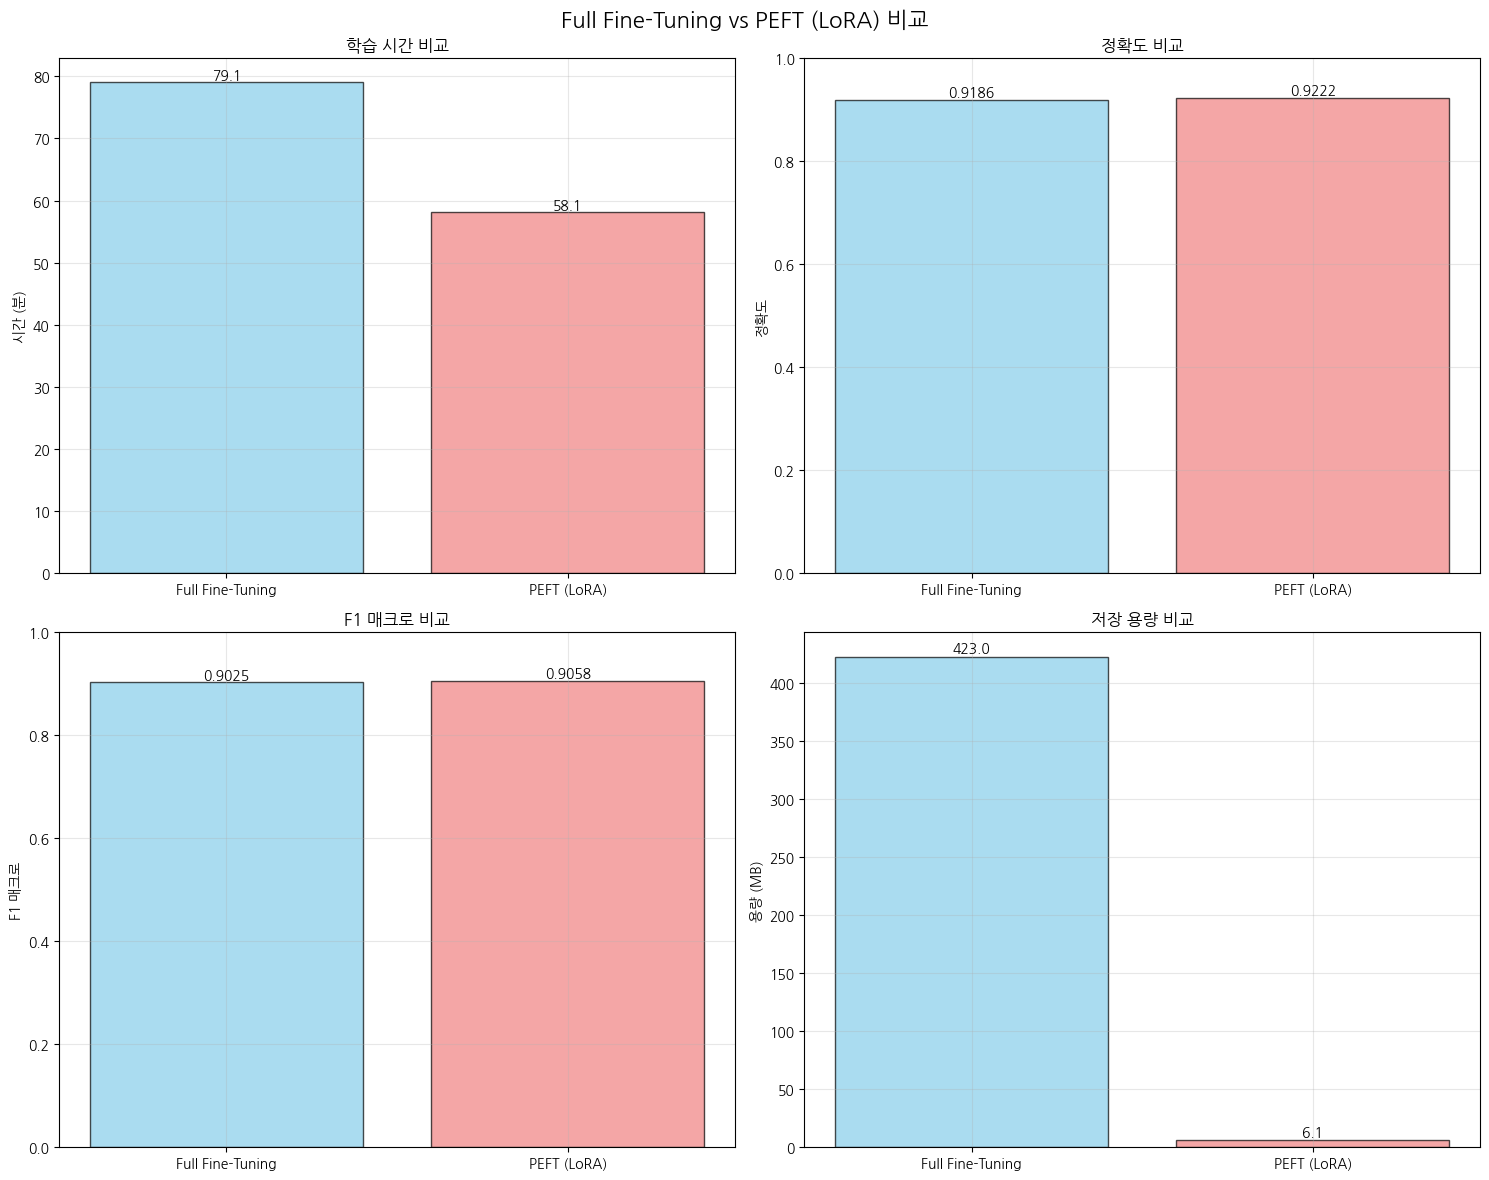


💡 PEFT 효율성 분석:
- 파라미터 절약: 98.8%
- 용량 절약: 98.6%
- 시간 절약: 26.5%
- 성능 유지도: +0.4%


In [11]:
# 비교 데이터 수집
comparison_data = {
    "방식": ["Full Fine-Tuning", "PEFT (LoRA)"],
    "학습시간(초)": [ft_train_time, peft_train_time],
    "학습시간(분)": [ft_train_time/60, peft_train_time/60],
    "정확도": [
        ft_eval_result.get("eval_accuracy", 0),
        peft_eval_result.get("eval_accuracy", 0)
    ],
    "F1_macro": [
        ft_eval_result.get("eval_f1_macro", 0),
        peft_eval_result.get("eval_f1_macro", 0)
    ],
    "F1_weighted": [
        ft_eval_result.get("eval_f1_weighted", 0),
        peft_eval_result.get("eval_f1_weighted", 0)
    ],
    "저장용량(MB)": [ft_size_mb, peft_size_mb],
    "학습파라미터": [trainable_params, trainable_params_peft]
}

# DataFrame 생성
comparison_df = pd.DataFrame(comparison_data)

# 결과 출력
print("\n" + "="*80)
print("📊 Full Fine-Tuning vs PEFT (LoRA) 비교 결과")
print("="*80)
display(comparison_df.round(4))

# 성능 비교 계산
time_ratio = peft_train_time / ft_train_time
size_ratio = peft_size_mb / ft_size_mb
acc_ratio = comparison_data["정확도"][1] / comparison_data["정확도"][0]
f1_ratio = comparison_data["F1_macro"][1] / comparison_data["F1_macro"][0]
param_ratio = trainable_params_peft / trainable_params

print(f"\n🔍 상대적 비교 (PEFT / Full FT):")
print(f"- 학습 시간: {time_ratio:.2f}x ({'빠름' if time_ratio < 1 else '느림'})")
print(f"- 저장 용량: {size_ratio:.3f}x ({'적음' if size_ratio < 1 else '많음'})")
print(f"- 정확도: {acc_ratio:.3f}x ({'높음' if acc_ratio > 1 else '낮음'})")
print(f"- F1 매크로: {f1_ratio:.3f}x ({'높음' if f1_ratio > 1 else '낮음'})")
print(f"- 학습 파라미터: {param_ratio:.4f}x ({'적음' if param_ratio < 1 else '많음'})")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Full Fine-Tuning vs PEFT (LoRA) 비교', fontsize=16, fontweight='bold')

# 1. 학습 시간 비교
bars1 = axes[0, 0].bar(comparison_df["방식"], comparison_df["학습시간(분)"], 
                       color=['skyblue', 'lightcoral'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('학습 시간 비교', fontweight='bold')
axes[0, 0].set_ylabel('시간 (분)')
axes[0, 0].grid(True, alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. 정확도 비교
bars2 = axes[0, 1].bar(comparison_df["방식"], comparison_df["정확도"], 
                       color=['skyblue', 'lightcoral'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('정확도 비교', fontweight='bold')
axes[0, 1].set_ylabel('정확도')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. F1 매크로 비교
bars3 = axes[1, 0].bar(comparison_df["방식"], comparison_df["F1_macro"], 
                       color=['skyblue', 'lightcoral'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('F1 매크로 비교', fontweight='bold')
axes[1, 0].set_ylabel('F1 매크로')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. 저장 용량 비교
bars4 = axes[1, 1].bar(comparison_df["방식"], comparison_df["저장용량(MB)"], 
                       color=['skyblue', 'lightcoral'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('저장 용량 비교', fontweight='bold')
axes[1, 1].set_ylabel('용량 (MB)')
axes[1, 1].grid(True, alpha=0.3)
for bar in bars4:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 파라미터 효율성 계산
print(f"\n💡 PEFT 효율성 분석:")
print(f"- 파라미터 절약: {((trainable_params - trainable_params_peft) / trainable_params * 100):.1f}%")
print(f"- 용량 절약: {((ft_size_mb - peft_size_mb) / ft_size_mb * 100):.1f}%")
print(f"- 시간 절약: {((ft_train_time - peft_train_time) / ft_train_time * 100):.1f}%")
print(f"- 성능 유지도: {((comparison_data['정확도'][1] / comparison_data['정확도'][0] - 1) * 100):+.1f}%")

## 🧪 테스트 데이터 최종 평가

In [12]:
# Full FT 모델 테스트 평가
print("🧪 Full Fine-Tuning 모델 테스트 평가")
ft_test_result = ft_trainer.evaluate(eval_dataset=tok_datasets["test"])
print("Full FT 테스트 결과:")
for key, value in ft_test_result.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

# PEFT 모델 테스트 평가
print("\n🧪 PEFT (LoRA) 모델 테스트 평가")
peft_test_result = peft_trainer.evaluate(eval_dataset=tok_datasets["test"])
print("PEFT 테스트 결과:")
for key, value in peft_test_result.items():
    if isinstance(value, float):
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

# 테스트 결과 비교
test_comparison = {
    "방식": ["Full Fine-Tuning", "PEFT (LoRA)"],
    "테스트_정확도": [
        ft_test_result.get("eval_accuracy", 0),
        peft_test_result.get("eval_accuracy", 0)
    ],
    "테스트_F1_macro": [
        ft_test_result.get("eval_f1_macro", 0),
        peft_test_result.get("eval_f1_macro", 0)
    ],
    "테스트_F1_weighted": [
        ft_test_result.get("eval_f1_weighted", 0),
        peft_test_result.get("eval_f1_weighted", 0)
    ]
}

test_comparison_df = pd.DataFrame(test_comparison)
print("\n📊 테스트 데이터 최종 비교:")
display(test_comparison_df.round(4))

🧪 Full Fine-Tuning 모델 테스트 평가
Full FT 테스트 결과:
- eval_loss: 0.2746
- eval_accuracy: 0.9240
- eval_f1_macro: 0.9098
- eval_f1_weighted: 0.9245
- eval_runtime: 70.5859
- eval_samples_per_second: 85.8810
- eval_steps_per_second: 10.7390
- epoch: 2.0000

🧪 PEFT (LoRA) 모델 테스트 평가
PEFT 테스트 결과:
- eval_loss: 0.2185
- eval_accuracy: 0.9268
- eval_f1_macro: 0.9136
- eval_f1_weighted: 0.9270
- eval_runtime: 91.4101
- eval_samples_per_second: 66.3170
- eval_steps_per_second: 8.2920
- epoch: 2.0000

📊 테스트 데이터 최종 비교:


,방식,테스트_정확도,테스트_F1_macro,테스트_F1_weighted
0,Full Fine-Tuning,0.9240,0.9098,0.9245
1,PEFT (LoRA),0.9268,0.9136,0.9270


## 📝 결론 및 분석

In [15]:
print("="*80)
print("🎯 쇼핑몰 리뷰 감성 분석 미션 결과 요약")
print("="*80)

# 주요 메트릭 추출
ft_acc = ft_test_result.get("eval_accuracy", 0)
peft_acc = peft_test_result.get("eval_accuracy", 0)
ft_f1 = ft_test_result.get("eval_f1_macro", 0)
peft_f1 = peft_test_result.get("eval_f1_macro", 0)

# 최종 결과 출력
print(f"\n📊 최종 성능 비교:")
print(f"- Full Fine-Tuning 정확도: {ft_acc:.4f}")
print(f"- PEFT (LoRA) 정확도: {peft_acc:.4f}")
print(f"- 정확도 차이: {(peft_acc - ft_acc):+.4f} ({(peft_acc/ft_acc - 1)*100:+.1f}%)")
print(f"- Full Fine-Tuning F1: {ft_f1:.4f}")
print(f"- PEFT (LoRA) F1: {peft_f1:.4f}")
print(f"- F1 차이: {(peft_f1 - ft_f1):+.4f} ({(peft_f1/ft_f1 - 1)*100:+.1f}%)")

print(f"\n⏱️  효율성 비교:")
print(f"- 학습 시간 절약: {((ft_train_time - peft_train_time) / ft_train_time * 100):.1f}%")
print(f"- 저장 용량 절약: {((ft_size_mb - peft_size_mb) / ft_size_mb * 100):.1f}%")
print(f"- 파라미터 절약: {((trainable_params - trainable_params_peft) / trainable_params * 100):.1f}%")

# 결론
print(f"\n🎖️  결론:")
if peft_acc >= ft_acc * 0.95:  # 95% 이상 성능 유지
    print("✅ PEFT가 Full Fine-Tuning의 성능을 95% 이상 유지하면서도")
    print("   학습 시간, 저장 용량, 파라미터 수에서 큰 효율성을 보여줍니다.")
    print("   실제 배포 시 PEFT 방식을 추천")
else:
    print("⚠️  PEFT의 성능이 Full Fine-Tuning에 비해 5% 이상 낮습니다.")
    print("   더 큰 LoRA 랭크(r)나 추가 학습을 고려해보세요.")

# 모델 저장 정보
print(f"\n💾 저장된 모델:")
print(f"- Full Fine-Tuning: {FT_DIR} ({ft_size_mb:.1f} MB)")
print(f"- PEFT 어댑터: {PEFT_DIR} ({peft_size_mb:.1f} MB)")

# 실험 설정 요약
print(f"\n🔧 실험 설정:")
print(f"- 모델: {BASE_MODEL_NAME}")
print(f"- 최대 토큰 길이: {MAX_LENGTH}")
print(f"- 배치 크기: {BATCH_SIZE}")
print(f"- 에폭: {EPOCHS}")
print(f"- Full FT 학습률: {LR_FT}")
print(f"- PEFT 학습률: {LR_PEFT}")
print(f"- LoRA 랭크: 8")
print(f"- LoRA 알파: 16")
print(f"- LoRA 드롭아웃: 0.05")
print(f"- 시드: {SEED}")
print(f"- 총 데이터: {len(df):,}")

🎯 쇼핑몰 리뷰 감성 분석 미션 결과 요약

📊 최종 성능 비교:
- Full Fine-Tuning 정확도: 0.9240
- PEFT (LoRA) 정확도: 0.9268
- 정확도 차이: +0.0028 (+0.3%)
- Full Fine-Tuning F1: 0.9098
- PEFT (LoRA) F1: 0.9136
- F1 차이: +0.0038 (+0.4%)

⏱️  효율성 비교:
- 학습 시간 절약: 26.5%
- 저장 용량 절약: 98.6%
- 파라미터 절약: 98.8%

🎖️  결론:
✅ PEFT가 Full Fine-Tuning의 성능을 95% 이상 유지하면서도
   학습 시간, 저장 용량, 파라미터 수에서 큰 효율성을 보여줍니다.
   실제 배포 시 PEFT 방식을 추천

💾 저장된 모델:
- Full Fine-Tuning: outputs/full_ft_model (423.0 MB)
- PEFT 어댑터: outputs/peft_lora_adapter (6.1 MB)

🔧 실험 설정:
- 모델: klue/bert-base
- 최대 토큰 길이: 256
- 배치 크기: 8
- 에폭: 2
- Full FT 학습률: 5e-05
- PEFT 학습률: 0.0001
- LoRA 랭크: 8
- LoRA 알파: 16
- LoRA 드롭아웃: 0.05
- 시드: 42
- 총 데이터: 40,408
